# Anomaly Detection - Isolation Forests

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
from sklearn.ensemble import IsolationForest

import seaborn
from scipy.spatial.distance import pdist, squareform

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
cyclists_dataset = pd.read_csv('../data/cyclists_dataset_fe.csv', dtype={'cyclist_team': str})
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cyclist_url      6095 non-null   object 
 1   mean_cyclist_cp  5011 non-null   float64
 2   mean_delta       6095 non-null   float64
 3   mean_position    6095 non-null   float64
 4   birth_year       6095 non-null   int64  
 5   weight           3134 non-null   float64
 6   height           3134 non-null   float64
 7   nationality      6095 non-null   object 
 8   cyclist_name     6095 non-null   object 
 9   cyclist_bmi      3134 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 476.3+ KB


In [3]:
races_dataset = pd.read_csv('../data/races_dataset_fe.csv')
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')
races_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140006 entries, 0 to 140005
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_url              140006 non-null  object        
 1   race_name             140006 non-null  object        
 2   points                140006 non-null  float64       
 3   uci_points            101148 non-null  float64       
 4   length                140006 non-null  float64       
 5   climb_total           113391 non-null  float64       
 6   profile               113391 non-null  float64       
 7   startlist_quality     140006 non-null  int64         
 8   date                  140006 non-null  datetime64[ns]
 9   mostly_tarmac         140006 non-null  bool          
 10  delta                 140006 non-null  float64       
 11  race_year             140006 non-null  int64         
 12  race_stage            140006 non-null  object        
 13 

In [4]:
complete_dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
complete_dataset['date'] = pd.to_datetime(complete_dataset['date'], format='%Y-%m-%d')
complete_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   cyclist_url               589739 non-null  object        
 1   cyclist_name              589739 non-null  object        
 2   birth_year                589739 non-null  int64         
 3   weight                    480007 non-null  float64       
 4   height                    480007 non-null  float64       
 5   nationality               589739 non-null  object        
 6   race_url                  589739 non-null  object        
 7   race_name                 589739 non-null  object        
 8   points                    589739 non-null  float64       
 9   uci_points                422184 non-null  float64       
 10  length                    589739 non-null  float64       
 11  climb_total               475338 non-null  float64       
 12  pr

## Anomaly Detection - Cyclists Dataset

<Axes: >

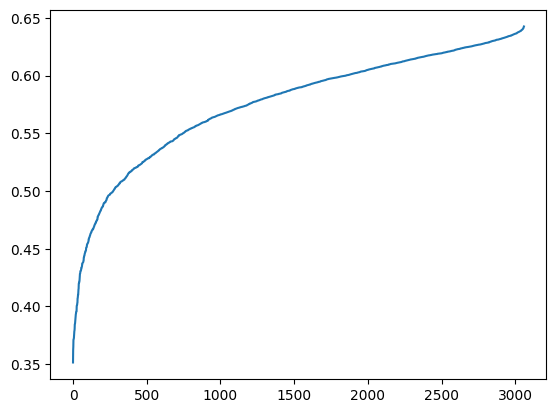

In [5]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = cyclists_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = cyclists_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [6]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

89

In [7]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,mean_cyclist_cp,mean_delta,mean_position,birth_year,weight,height,cyclist_bmi,isolation_forest_degree,isolation_forest_scores
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.0
mean,0.019610,667.586499,0.551846,1973.179775,71.906742,178.842697,22.377146,0.416170,1.0
std,0.031213,1060.947042,0.242527,18.558606,11.959114,10.980250,2.436444,0.025712,0.0
min,0.000002,3.000000,0.044118,1940.000000,48.000000,154.000000,16.604275,0.351433,1.0
25%,0.000315,154.980922,0.374769,1954.000000,62.000000,172.000000,20.500000,0.395424,1.0
50%,0.002585,360.563380,0.527323,1980.000000,74.000000,180.000000,22.308150,0.422265,1.0
75%,0.027786,776.424779,0.755218,1986.000000,81.000000,186.000000,24.207903,0.437745,1.0
max,0.107286,7291.800000,1.000000,2003.000000,94.000000,204.000000,27.770313,0.448778,1.0


In [8]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/cyclists_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Races Dataset

<Axes: >

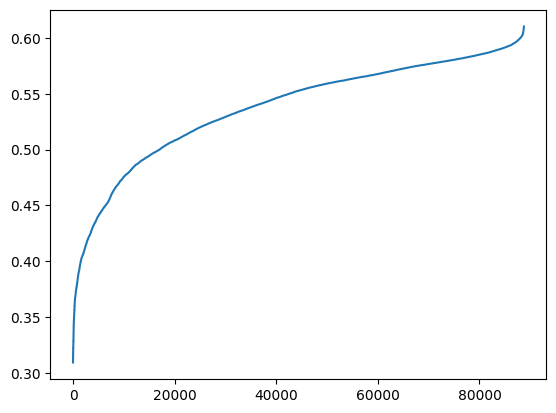

In [9]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = races_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = races_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [10]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

6411

In [11]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,date,delta,race_year,climb_percentage,race_physical_effort,race_prestige,isolation_forest_degree,isolation_forest_scores
count,6411.000000,6411.000000,6411.000000,6411.000000,6411.000000,6411.000000,6411,6411.000000,6411.000000,6411.000000,6411.000000,6411.000000,6411.000000,6411.0
mean,193.687412,333.011699,186.148822,3.227150,2.997348,1048.294962,2012-02-03 03:43:15.975666944,536.081423,2011.640774,0.062290,0.212744,0.316846,0.416030,1.0
min,20.000000,6.000000,1.900000,0.083000,1.000000,156.000000,2001-03-28 00:00:00,0.000000,2001.000000,0.000409,0.000398,0.000000,0.309243,1.0
25%,80.000000,20.000000,165.700000,1.863000,2.000000,816.000000,2005-08-13 00:00:00,94.000000,2005.000000,0.008386,0.038628,0.162617,0.401216,1.0
50%,225.000000,400.000000,225.000000,3.430000,3.000000,1025.000000,2011-05-22 00:00:00,319.000000,2011.000000,0.016938,0.146800,0.314999,0.422414,1.0
75%,275.000000,500.000000,257.500000,4.520000,5.000000,1191.000000,2018-07-25 00:00:00,688.000000,2018.000000,0.029340,0.280378,0.439123,0.439244,1.0
max,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,25223.000000,2023.000000,0.981053,0.910685,0.908128,0.449967,1.0
std,101.149693,228.481863,97.252219,1.649485,1.494501,326.499348,NaN,688.849986,7.091949,0.120557,0.222051,0.188698,0.028298,0.0


In [12]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/races_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Cyclist + Races Merged Dataset

<Axes: >

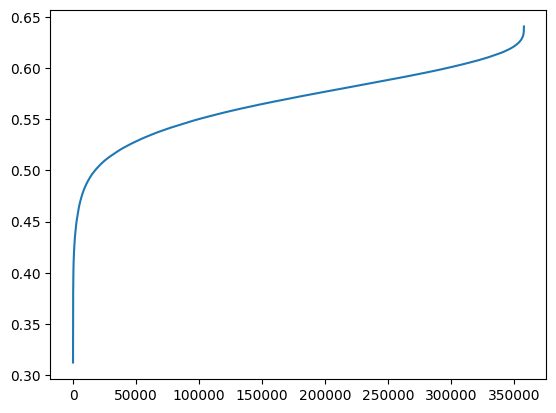

In [13]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = complete_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = complete_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [14]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

2808

In [15]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,race_physical_effort,race_prestige,mean_cyclist_cp,mean_delta,mean_position,cumulative_mean_position,cumulative_mean_delta,cumulative_mean_cp,isolation_forest_degree,isolation_forest_scores
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808,...,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2.808000e+03,2808.000000,2808.0
mean,1981.640313,69.730520,179.762108,201.420940,306.030271,199.288405,3.200577,3.217593,1206.894231,2010-11-26 12:40:00,...,0.304270,0.397239,0.032902,517.870770,0.452922,0.460840,570.834291,5.324821e-02,0.426860,1.0
min,1963.000000,48.000000,159.000000,20.000000,6.000000,1.150000,0.002000,1.000000,156.000000,2001-03-31 00:00:00,...,0.000000,0.000000,0.000002,50.698113,0.102442,0.040230,0.000000,2.646021e-07,0.312328,1.0
25%,1978.000000,64.000000,175.000000,80.000000,20.000000,171.000000,1.864000,2.000000,975.000000,2006-04-09 00:00:00,...,0.046385,0.130478,0.004640,222.745429,0.322609,0.309595,190.242775,3.335034e-03,0.417726,1.0
50%,1982.000000,70.000000,178.000000,125.000000,300.000000,232.000000,3.561000,3.000000,1247.000000,2009-09-27 00:00:00,...,0.254124,0.285028,0.015570,442.724657,0.447691,0.455955,399.050193,1.397985e-02,0.432968,1.0
75%,1985.000000,75.000000,184.000000,350.000000,600.000000,260.400000,4.566000,5.000000,1439.000000,2014-09-29 18:00:00,...,0.566410,0.694693,0.060136,773.507862,0.560263,0.573940,714.146465,8.039902e-02,0.442605,1.0
max,2002.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,0.910685,0.908128,0.107286,7291.800000,1.000000,1.000000,25223.000000,4.860239e-01,0.449997,1.0
std,7.038262,7.586234,6.840154,127.217671,274.021927,83.495858,1.574003,1.668464,331.716514,NaN,...,0.253598,0.275283,0.033472,463.114630,0.181060,0.193556,857.308175,7.656223e-02,0.021358,0.0


In [16]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/complete_dataset_no_outliers.csv', index=False)